# 一、调用的包了解下

In [1]:
#调用的包信息
import re  
import pickle
import random
import pandas as pd
import numpy as np
import jieba

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.svm import SVC
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.model_selection import train_test_split

# 二、探索性分析

## 1、获取原始数据

In [3]:
with open(r'D:\分析实战\京东评论文本挖掘\data\京东评论数据.csv', encoding='utf-8') as f:
    data = pd.read_csv(f)

## 2、数据观测

In [4]:
#数据审核及矫正
def DataOverview(data):
    print('Data Overview:')
    print(data.head(4))
    print('-'*30)
    print('Data Information')
    print(data.info())
    print('-'*40)
    print('Data DESC:')
    print(data.describe())
    print('-'*60)

DataOverview(data)

Data Overview:
    sku_id                                   _id item_name   comment_id  \
0  7534113  03b51aa9-2b5e-41c3-a40b-343164a1d23a   comment  11801751173   
1  7534113  03b51aa9-2b5e-41c3-a40b-343164a1d23a   comment  11525358140   
2  7534113  03b51aa9-2b5e-41c3-a40b-343164a1d23a   comment  11787681311   
3  8240587  082df194-97f0-425e-85ac-8596344114e6   comment  11726613552   

                                             content        creation_time  \
0                                 还可以刷脸解锁，帮朋友买的，她很满意  2018-08-13 12:24:59   
1  第一次买vivo，真心不错，1498的机子，没想到照相很清晰，性价比很高，买值了，还送了小音...  2018-05-27 17:49:17   
2                                         手机好用快递送的快。  2018-08-09 07:17:37   
3  手机收到。外观设计很好！美观大方。我喜欢！一直使用华为手机。从荣耀七，荣耀八，荣耀九。反正一...  2018-07-21 13:29:44   

   reply_count  score  useful_vote_count  useless_vote_count  \
0            0      5                  0                   0   
1            7      5                 19                   0   
2            0      5          

#### 数据集大小21*3637；时间字段为数值型需转化为日期型；“score“，”reply_count"字段存在样本不均衡的情况。

In [5]:
#缺失值审核
def MissingView(data):
    na_cols = data.isnull().any(axis=0)  # 查看每一列是否具有缺失值
    print ('NA Cols:')
    print (na_cols)  # 查看具有缺失值的列
    print ('-' * 30)
    na_lines = data.isnull().any(axis=1)  # 查看每一行是否具有缺失值
    print ('NA Recors:')
    print ('Total number of NA lines is: {0}'.format(na_lines.sum()))  # 查看具有缺失值的行总记录数
    print (data[na_lines])  # 只查看具有缺失值的行信息
    print ('-' * 60)
    
MissingView(data)

NA Cols:
sku_id                False
_id                   False
item_name             False
comment_id            False
content               False
creation_time         False
reply_count           False
score                 False
useful_vote_count     False
useless_vote_count    False
user_level_id         False
user_province          True
nickname              False
user_level_name       False
user_client           False
user_client_show       True
is_mobile              True
days                   True
reference_time         True
after_days             True
after_user_comment     True
dtype: bool
------------------------------
NA Recors:
Total number of NA lines is: 3637
           sku_id                                   _id item_name  \
0         7534113  03b51aa9-2b5e-41c3-a40b-343164a1d23a   comment   
1         7534113  03b51aa9-2b5e-41c3-a40b-343164a1d23a   comment   
2         7534113  03b51aa9-2b5e-41c3-a40b-343164a1d23a   comment   
3         8240587  082df194-97f0-425e-8

#### 存在"user_province"、"user_level_name"字段存在缺失的情况。两个字段不影响后续分析，不做相关处理。

## 3、文本评分分布情况

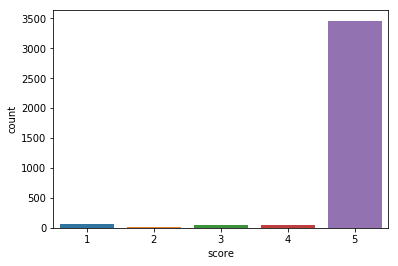

In [6]:
data['score'].value_counts()
sns.countplot(data=data,x='score')

#### 可以看出评论文本出现好评和差评不均衡情况，其中好评远大于差

## 4、评论发布时间分布情况

In [7]:
#数据转化
data['creation_time'] = pd.to_datetime(data['creation_time'])
data['reference_time'] = pd.to_datetime(data['reference_time'])

data['year'] = data.creation_time.dt.year
data['month'] = data.creation_time.dt.month
data['weekday'] = data.creation_time.dt.weekday
data['hour'] = data.creation_time.dt.hour

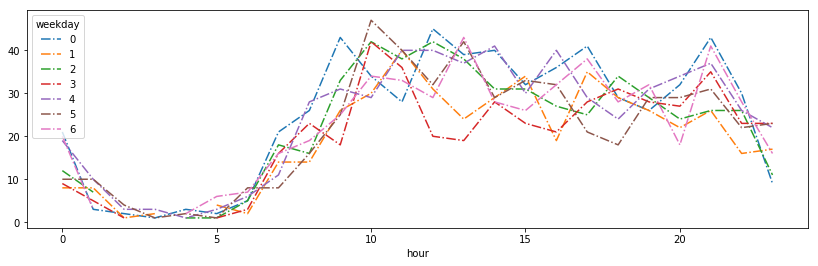

In [8]:
#观测每周评论数数据变化情况
fig1, ax1=plt.subplots(figsize=(14,4))
df=data.groupby(['hour', 'weekday']).count()['nickname'].unstack()
df.plot(ax=ax1, style='-.')
plt.show()

#### 每周一到周日用户评论情况趋势相对相同，用户活跃时间主要集中在8点到20点时段。深夜活跃度低可能大部分用户在睡觉

## 5、评论长度与评分关系情况

(0, 600)

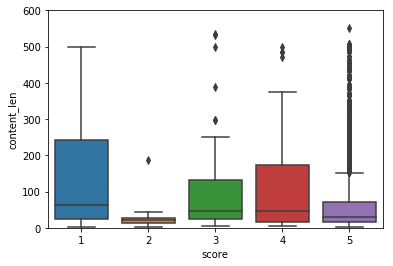

In [9]:
#评论的长短可以看出评论者的认真程度
data['content_len'] = data['content'].str.len()
fig2, ax2=plt.subplots()
sns.boxplot(x='score',y='content_len',data=data, ax=ax2)
ax2.set_ylim(0,600)

#### 可以看出1星的用户评论长，说明不满意的用户提供更多信息

# 三、文本预处理

In [10]:
#提取需处理的数据及标签
data1 = data[['content', 'score']]
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3637 entries, 0 to 3636
Data columns (total 2 columns):
content    3637 non-null object
score      3637 non-null int64
dtypes: int64(1), object(1)
memory usage: 56.9+ KB


In [11]:
#获取停用词
with open(r'D:\分析实战\京东评论文本挖掘\data\哈工大停用词表.txt', encoding='gbk') as file:
    word_list = [x.strip() for x in file.readlines()]

#### 1、构建情感标签， 京东评分为1-5分，对于我们做的情感分析作用不大，可以重新划分标签，作为训练模型的语料。即划分方式为： 划分为4-5分好评，1-3分差评。

In [12]:
def SetLabel(score):
    if score >=4:
        return 1 
    else:
        return 0
    
data1['score'] = data1['score'].map(lambda x:SetLabel(x))

C:\LOCATION\development tool\shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


#### 2、中文分词：著名的nltk包对分词有良好的效果，劣势在于对中文不友好。对此选用jieba包进行处理。这里我们把文本通过空格形式分词。为了更好了解jieba中文分词详细用法，提供下友情链接做参考：https://github.com/fxsjy/jieba

In [13]:
# 分词函数
data1['seg_words'] = data1['content'].apply(lambda x: ' '.join(jieba.cut(x)))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\zero\AppData\Local\Temp\jieba.cache
Loading model cost 0.735 seconds.
Prefix dict has been built succesfully.
C:\LOCATION\development tool\shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### 3、特征选取：拆分好的文本不能直接扔去建模，还需要把文本转化为稀疏矩阵。主要手段嘛，词袋模型、TF-IDF等，这里主要采用TF-IDF方法。附上链接了解下TF-IDF基本原理：http://www.ruanyifeng.com/blog/2013/03/tf-idf.html

In [14]:
#数据集拆分为语料、标签
terms = data1['seg_words'].tolist()
y = data1['score'].tolist()

from sklearn.feature_extraction.text import TfidfVectorizer as TFIV
# 初始化TFIV对象，去停用词，加2元语言模型  
tfv = TFIV(min_df=3,  max_features=None, strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
           ngram_range=(1, 2), use_idf=1,smooth_idf=1,sublinear_tf=1, stop_words = word_list)  

tfv.fit(terms)
X_all = tfv.transform(terms)

C:\LOCATION\development tool\shared\Anaconda3_64\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1a', '1b', '1c', '1d', '1e', '1f', '1g', '1h', '1i', '1o', '2', '21', '210', '22', '23', '24', '25', '26', '27', '28', '2a', '2b', '2c', '2d', '2e', '2f', '2g', '2h', '2i', '2j', '3', '31', '310', '3a', '3b', '3c', '3d', '3e', '3f', '3g', '3h', '4', '4a', '4b', '4c', '4d', '4e', '5', '5a', '5b', '5d', '5e', '5f', '6', '7', '8', '9', 'C', '_', 'a', 'b', 'c', 'e', 'f', 'iii', 'l', 'lex', 'li', 'ng昉', 'r', 'zxfitl', 'β', 'δ', 'λ', 'ξ', 'ψ', 'в', '元', '八', '吨', '数', '日', '末'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


#### 4、分类模型前的特征选择：将文本进行特征表示后，还进行特征选择，选出较优的特征。这一步操作可以有效特省模型性能，改善模型。本次模型选用卡方检验选取100个特征。其他特征选择方法不展开讲述，此处搬运工附上链接供学习。https://blog.csdn.net/Bryan__/article/details/51607215

In [15]:
#特征选择
from sklearn.feature_selection import SelectKBest, chi2
select_feature_model = SelectKBest(chi2, k=100)    ##卡方检验来选择100个最佳特征
X_all = select_feature_model.fit_transform(X_all, y)  #减少特征的数量，达到降维的效果，从而使模型的方法能力更强，降低过拟合的风险

# 四、模型建立与选择

使用机器学习去做情感分析。特征值是评论文本经过TF-IDF处理的向量，标签值评论分类为1（好评）、0（差评）。主要选取模型有：朴素贝叶斯、逻辑回归、SVM。对比下模型拟合效果。

In [16]:
#切分测试集、训练集
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_all, y, random_state=0, test_size=0.25)

## 1、朴素贝叶斯

In [17]:
model_NB = MNB()
model_NB.fit(x_train, y_train) #特征数据直接灌进来
MNB(alpha=1.0, class_prior=None, fit_prior=True) # ”alpha“是平滑参数，不需要掌握哈。

from sklearn.model_selection import cross_val_score
#评估预测性能，减少过拟合
print("贝叶斯分类器20折交叉验证得分: ", np.mean(cross_val_score(model_NB, x_train, y_train, cv=20, scoring='roc_auc')))   

贝叶斯分类器20折交叉验证得分:  0.42522380291464257


## 2、逻辑回归

In [18]:
# 折腾一下逻辑回归
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import GridSearchCV

model_LR = LogisticRegression(C=.01) # C是正则化系数。
model_LR.fit(x_train, y_train)
print("20折交叉验证得分: ", np.mean(cross_val_score(model_LR, x_train, y_train, cv=20, scoring='roc_auc')))

20折交叉验证得分:  0.7847334991132702


C:\LOCATION\development tool\shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\LOCATION\development tool\shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## 3、SVM

In [19]:
from sklearn.svm import LinearSVC
model_SVM = LinearSVC(C=.01) # C是正则化系数。
model_SVM.fit(x_train, y_train)
print("20折交叉验证得分: ", np.mean(cross_val_score(model_SVM, x_train, y_train, cv=20, scoring='roc_auc')))

20折交叉验证得分:  0.827218077723803


## 4、其他模型效果评估情况

插播一下模型效果评估方法主要有准确率(Accuracy)、精确率(Precision)、召回率(Recall)、F1-score、ROC、AUC。最好采用roc_auc评估方法，因为其他方法只能片面评估效果，不能全面衡量模型性能。
下面尝试下使用cross_val_score默认方法尝试评估结果KFold或者stratifiedKFold。了解这几个效果评估方法得区别，看下链接：https://blog.csdn.net/zuolixiangfisher/article/details/81328297

In [20]:
model_LR = LogisticRegression(C=.01) # C是正则化系数。
model_LR.fit(x_train, y_train)
print("20折交叉验证得分: ", np.mean(cross_val_score(model_LR, x_train, y_train, cv=20)))

20折交叉验证得分:  0.9629667052476341


C:\LOCATION\development tool\shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\LOCATION\development tool\shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [21]:
model_SVM = LinearSVC(C=.01) # C是正则化系数。
model_SVM.fit(x_train, y_train)
print("20折交叉验证得分: ", np.mean(cross_val_score(model_SVM, x_train, y_train, cv=20)))

20折交叉验证得分:  0.9629667052476341


三种模型拟合并输出结果下，可以得到SVM分类效果最佳

## 5、混淆矩阵评估分类模型预测效果

In [22]:
from sklearn.metrics import confusion_matrix
y_predict = model_SVM.predict(x_test)
cm = confusion_matrix(y_test, y_predict)
cm

array([[  0,  26],
       [  0, 884]], dtype=int64)

可以看出，负类的预测非常不准，准确预测为负类的0%，应该是由于数据不平衡导致的，模型的默认阈值为输出值的中位数。比如逻辑回归的输出范围为[0,1]，当某个样本的输出大于0.5就会被划分为正例，反之为反例。在数据的类别不平衡时，采用默认的分类阈值可能会导致输出全部为正例，产生虚假的高准确度，导致分类失败。 处理样本不均衡问题的方法，首先可以选择调整阈值，使得模型对于较少的类别更为敏感，或者选择合适的评估标准，比如ROC或者F1，而不是准确度（accuracy）。另外一种方法就是通过采样（sampling）来调整数据的不平衡。其中欠采样抛弃了大部分正例数据，从而弱化了其影响，可能会造成偏差很大的模型，同时，数据总是宝贵的，抛弃数据是很奢侈的。另外一种是过采样，下面我们就使用过采样方法来调整。

# 五、过采样后，进行建模

SMOTE（Synthetic minoritye over-sampling technique,SMOTE），是在局部区域通过K-近邻生成了新的反例。对SMOTE感兴趣的同学可以看下这篇文章https://www.jianshu.com/p/ecbc924860af

In [23]:
def sample_balabce(X, y):
    from imblearn.over_sampling import SMOTE
    model_smote = SMOTE()
    x_smote_resamples, y_smote_resamples = model_smote.fit_sample(X, y)
    return x_smote_resamples, y_smote_resamples

rex, rey = sample_balabce(X_all, y)
rex_train, rex_test, rey_train, rey_test = train_test_split(rex, rey, 
                random_state=0, test_size=0.25)

In [24]:
#使用过采样样本(简单复制)进行模型训练，并查看准确率
from sklearn.svm import LinearSVC
model_SVM = LinearSVC(C=.01) # C是正则化系数。
model_SVM.fit(rex_train, rey_train)
print("20折交叉验证得分: ", np.mean(cross_val_score(model_SVM, rex_train, rey_train, cv=20, scoring='roc_auc')))

20折交叉验证得分:  0.8555073492492292


In [25]:
#查看此时的混淆矩阵
rey_predict = model_SVM.predict(rex_test)
cm = confusion_matrix(rey_test, rey_predict)
cm

array([[556, 322],
       [141, 736]], dtype=int64)

通过过采样方法后SVM得效果有所上升，负样本的识别率大幅度上升。

# 六、后续优化方向

1、采用更复杂的模型，如神经网络
2、模型调参
3、构建行业词典等